In [1]:
import os
import numpy as np

def load_fasta(file_path):
    sequences = {}
    header = None
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('>'):
                header = line[1:]
                sequences[header] = ''
            else:
                sequences[header] += line
    return sequences[header]

def load_bpseq(file_path):
    structure = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 3:
                idx = int(parts[0])
                nucleotide = parts[1]
                pair = int(parts[2])
                structure.append((idx, nucleotide, pair))
    return structure

def load_data(fasta_dir, bpseq_dir):
    fasta_files = [f for f in os.listdir(fasta_dir) if f.endswith('.fa')]
    bpseq_files = [f for f in os.listdir(bpseq_dir) if f.endswith('.bpseq')]

    sequences = {}
    structures = {}

    for fasta_file in fasta_files:
        header = os.path.splitext(fasta_file)[0]
        fasta_path = os.path.join(fasta_dir, fasta_file)
        sequences[header] = load_fasta(fasta_path)

    for bpseq_file in bpseq_files:
        header = os.path.splitext(bpseq_file)[0]
        bpseq_path = os.path.join(bpseq_dir, bpseq_file)
        structures[header] = load_bpseq(bpseq_path)

    return sequences, structures

sequences, structures = load_data('PDB/', 'PDB/')
print("Liczba wczytanych sekwencji:", len(sequences))
print("Liczba wczytanych struktur:", len(structures))


Liczba wczytanych sekwencji: 590
Liczba wczytanych struktur: 590


In [2]:
def one_hot_encode_sequence(seq):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'U': 3}
    one_hot = np.zeros((len(seq), 4), dtype=int)
    for i, nucleotide in enumerate(seq):
        one_hot[i, mapping[nucleotide.upper()]] = 1
    return one_hot
encoded_sequences = {header: one_hot_encode_sequence(seq) for header, seq in sequences.items()}


In [3]:
def encode_structure(structure, seq_length):
    encoded = np.zeros(seq_length, dtype=int)

    for idx, _, pair in structure:
        if pair != 0:
            encoded[idx - 1] = 1
            encoded[pair - 1] = 1
    return encoded

encoded_structures = {header: encode_structure(struct, len(structures[header])) for header, struct in structures.items() if header in sequences.keys()}


In [4]:
print(f"Sequences keys: {list(sequences.keys())[:5]}")
print(f"Structures keys: {list(structures.keys())[:5]}")

print(f"Encoded sequences: {len(encoded_sequences)}")
print(f"Encoded structures: {len(encoded_structures)}")

Sequences keys: ['1A9N_1_Q', '1B23_1_R', '1E7K_1_C', '1EC6_1_C', '1EC6_1_D']
Structures keys: ['1A9N_1_Q', '1B23_1_R', '1E7K_1_C', '1EC6_1_C', '1EC6_1_D']
Encoded sequences: 590
Encoded structures: 590


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np


def prepare_data(sequences, structures, max_length):
    X_list = []
    y_list = []
    for header in sequences.keys():
        seq = sequences[header]
        struct = structures[header]
        seq_array = np.zeros((max_length, 4)) 
        struct_array = np.zeros(max_length)  
        
        # padding
        if len(seq) < max_length:
            pad_length = max_length - len(seq)
            seq = np.pad(seq, (0, pad_length), mode='constant')
        else:
            seq = seq[:max_length]
        
        for i in range(len(seq)):
            if seq[i] in ['A', 'C', 'G', 'U']:  # nuclei
                if seq[i] == 'A':
                    seq_array[i, 0] = 1
                elif seq[i] == 'C':
                    seq_array[i, 1] = 1
                elif seq[i] == 'G':
                    seq_array[i, 2] = 1
                elif seq[i] == 'U':
                    seq_array[i, 3] = 1
        
        # padding
        if len(struct) < max_length:
            pad_length = max_length - len(struct)
            struct = np.pad(struct, (0, pad_length), mode='constant')
        else:
            struct = struct[:max_length]
        
        for i in range(len(struct)):
            if struct[i] != 0:  
                struct_array[i] = 1
        
        X_list.append(seq_array)
        y_list.append(struct_array)
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    return X, y

max_sequence_length = 2968

X, y = prepare_data(encoded_sequences, encoded_structures, max_sequence_length)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


C:\Users\tomek\AppData\Local\Temp/ipykernel_11376/1578176892.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if seq[i] in ['A', 'C', 'G', 'U']:  # nuclei


In [6]:
import tensorflow as tf
model_pdb = tf.keras.models.load_model('model_archive.h5')


In [18]:
history_pdb = model_pdb.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
13/13 [==============================] - 42s 815ms/step - loss: 0.1805 - accuracy: 0.9581
Epoch 2/50
13/13 [==============================] - 10s 776ms/step - loss: 0.1804 - accuracy: 0.9581
Epoch 3/50
13/13 [==============================] - 10s 779ms/step - loss: 0.1803 - accuracy: 0.9581
Epoch 4/50
13/13 [==============================] - 10s 777ms/step - loss: 0.1802 - accuracy: 0.9581
Epoch 5/50
13/13 [==============================] - 11s 811ms/step - loss: 0.1801 - accuracy: 0.9581
Epoch 6/50
13/13 [==============================] - 11s 842ms/step - loss: 0.1800 - accuracy: 0.9581
Epoch 7/50
13/13 [==============================] - 11s 845ms/step - loss: 0.1799 - accuracy: 0.9581
Epoch 8/50
13/13 [==============================] - 10s 799ms/step - loss: 0.1798 - accuracy: 0.9581
Epoch 9/50
13/13 [==============================] - 11s 848ms/step - loss: 0.1797 - accuracy: 0.9581
Epoch 10/50
13/13 [==============================] - 12s 915ms/step - loss: 0.1796 - accura

In [18]:
history_pdb = model_pdb.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
13/13 [==============================] - 12s 928ms/step - loss: 0.1795 - accuracy: 0.9581 - val_loss: 0.1303 - val_accuracy: 0.9767
Epoch 2/10
13/13 [==============================] - 12s 904ms/step - loss: 0.1794 - accuracy: 0.9581 - val_loss: 0.1301 - val_accuracy: 0.9767
Epoch 3/10
13/13 [==============================] - 12s 891ms/step - loss: 0.1793 - accuracy: 0.9581 - val_loss: 0.1300 - val_accuracy: 0.9767
Epoch 4/10
13/13 [==============================] - 11s 882ms/step - loss: 0.1792 - accuracy: 0.9581 - val_loss: 0.1298 - val_accuracy: 0.9767
Epoch 5/10
13/13 [==============================] - 11s 865ms/step - loss: 0.1791 - accuracy: 0.9581 - val_loss: 0.1296 - val_accuracy: 0.9767
Epoch 6/10
13/13 [==============================] - 11s 816ms/step - loss: 0.1790 - accuracy: 0.9581 - val_loss: 0.1295 - val_accuracy: 0.9767
Epoch 7/10
13/13 [==============================] - 11s 823ms/step - loss: 0.1789 - accuracy: 0.9581 - val_loss: 0.1293 - val_accuracy: 0.9767

In [19]:
loss, accuracy = model_pdb.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

3/3 [==============================] - 1s 214ms/step - loss: 0.1196 - accuracy: 0.9802
Test Accuracy: 0.980170488357544


{'loss': [0.17948207259178162, 0.17938441038131714, 0.17929205298423767, 0.17920207977294922, 0.17911937832832336, 0.17902036011219025, 0.17893071472644806, 0.1788468211889267, 0.1787496954202652, 0.17867301404476166], 'accuracy': [0.9581165909767151, 0.9581165909767151, 0.9581165313720703, 0.9581165909767151, 0.9581165909767151, 0.9581165909767151, 0.9581166505813599, 0.9581165909767151, 0.9581165313720703, 0.9581165909767151], 'val_loss': [0.1302967071533203, 0.13014298677444458, 0.12998691201210022, 0.12982326745986938, 0.12964092195034027, 0.12947840988636017, 0.1293187141418457, 0.1291545331478119, 0.12901905179023743, 0.12886108458042145], 'val_accuracy': [0.9767060875892639, 0.9767060875892639, 0.9767060875892639, 0.9767060875892639, 0.9767060875892639, 0.9767060875892639, 0.9767060875892639, 0.9767060875892639, 0.9767060875892639, 0.9767060875892639]}


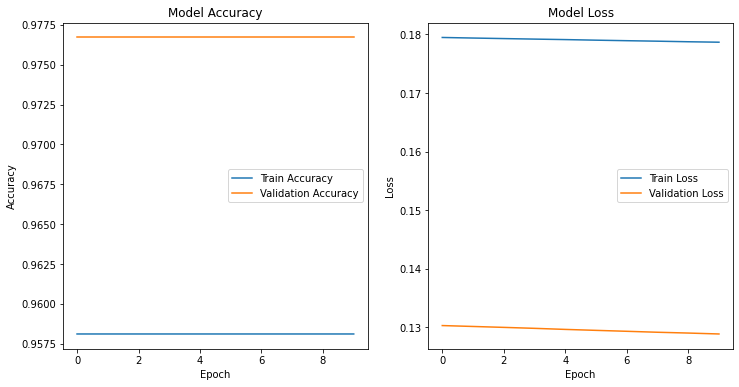

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_pdb.history['accuracy'], label='Train Accuracy')
plt.plot(history_pdb.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_pdb.history['loss'], label='Train Loss')
plt.plot(history_pdb.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()
plt.savefig("acc_val_pdb.pdf")